# SVMguide 1

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/svmguide1(3089,4).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/svmguide1_test(4000,4).txt')
data_name = 'svmguide'
print(x_test.shape)

# x_tr = x_tr.T
x_tr = x_tr.toarray()
# x_test = x_test.T
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape
print(num, dim)
print('of objects:', num)
print('of features:', dim)
print(data_name)

(4000, 4)
3089 4
of objects: 3089
of features: 4
svmguide


## K-Means cluster centers

In [3]:
ind_num = 25
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
cov_params = np.array([2., 2., 1.])

## svi-L-BFGS-B-c method

In [5]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [6]:
opts = {'mode': 'full', 'maxiter': 20, 'mydisp': False}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [7]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

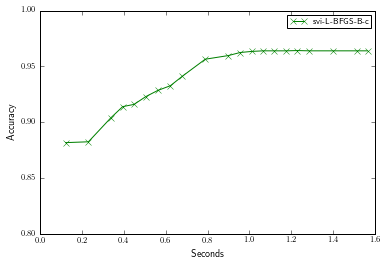

In [8]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method
Подбор числа пересчетов

In [9]:
maxfuns = [5, 10, 15, 20]
results = []
for maxfun in maxfuns:
    print(maxfun)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    vi_gp = GPC(model_covariance_obj, method='vi')
    opts = {'maxfun':maxfun, 'mydisp': False, 'num_updates':3}
    results.append(vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20))
    print()

5

10

15

20



0
1
2
3


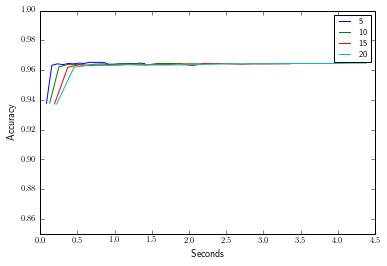

In [10]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(maxfuns)):
    vi_x_lst, vi_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(vi_x_lst[1:], vi_y_lst[1:], label=maxfuns[i])
    print(i)
plt.ylim([0.85, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Обучение лучшего варианта

In [11]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20)

Hyper-parameters at iteration 0 : [ 2.  2.  1.]
Hyper-parameters at iteration 1 : [ 2.16391843  1.99619749  0.9981083 ]
Hyper-parameters at iteration 2 : [ 2.28928455  1.87385807  0.01      ]
Hyper-parameters at iteration 3 : [ 2.45757101  1.80315158  0.01      ]
Hyper-parameters at iteration 4 : [ 2.97828133  1.57892528  0.01      ]
	Hyper-parameters at outter iteration 0 : [ 3.10454951  1.52920349  0.01      ]
Hyper-parameters at iteration 0 : [ 3.10454951  1.52920349  0.01      ]
Hyper-parameters at iteration 1 : [ 4.57935477  1.45213752  0.01      ]
	Hyper-parameters at outter iteration 1 : [ 4.54388183  1.45445359  0.01      ]
Hyper-parameters at iteration 0 : [ 4.54388183  1.45445359  0.01      ]
Hyper-parameters at iteration 1 : [ 4.55293439  1.47518661  0.01      ]
	Hyper-parameters at outter iteration 2 : [ 4.5540688   1.47502005  0.01      ]
Hyper-parameters at iteration 0 : [ 4.5540688   1.47502005  0.01      ]
Hyper-parameters at iteration 1 : [ 4.6365884   1.44779906  0.01

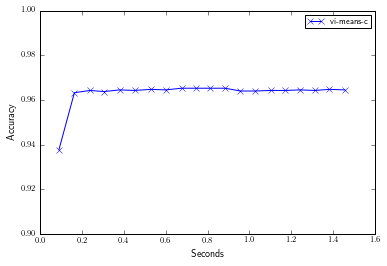

In [12]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подберем шаг для метода

In [14]:
results = []
steps = [1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': False, 'batch_size': 50, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2
3
4


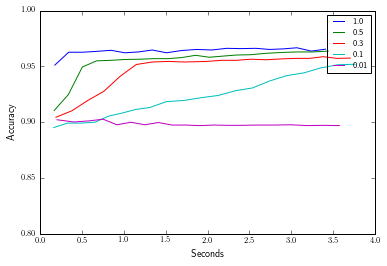

In [15]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [16]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': True, 'batch_size': 50, 
        'step_rate': 1., 'print_freq':2}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  1 :
	Gradient norm 2.3865160891
Iteration  3 :
	Gradient norm 6.16701392658
Iteration  5 :
	Gradient norm 2.99777933814
Iteration  7 :
	Gradient norm 3.63930112144
Iteration  9 :
	Gradient norm 4.11654297384
Iteration  11 :
	Gradient norm 1.96243361553
Iteration  13 :
	Gradient norm 1.92118747325
Iteration  15 :
	Gradient norm 6.85320778895
Iteration  17 :
	Gradient norm 7.76141614637
Iteration  19 :
	Gradient norm 5.15762091498


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


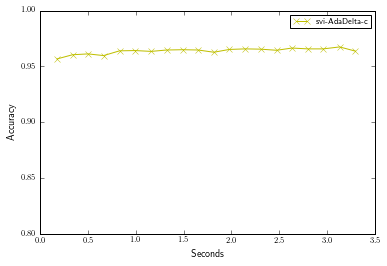

In [17]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

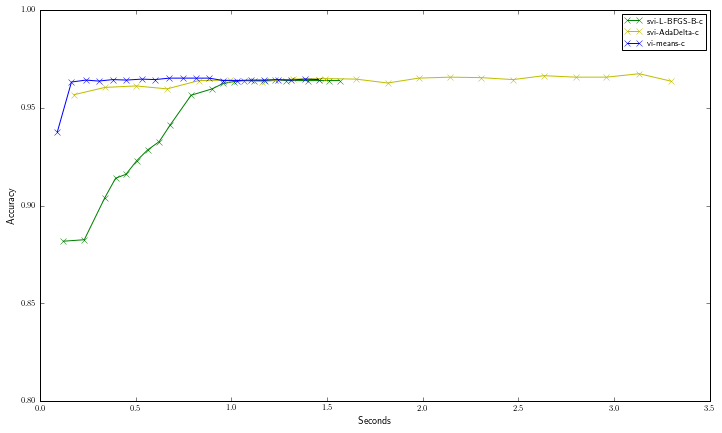

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:50], svi_ad_y_lst[1:50], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:100], vi_y_lst[1:100], '-bx', label='vi-means-c')
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

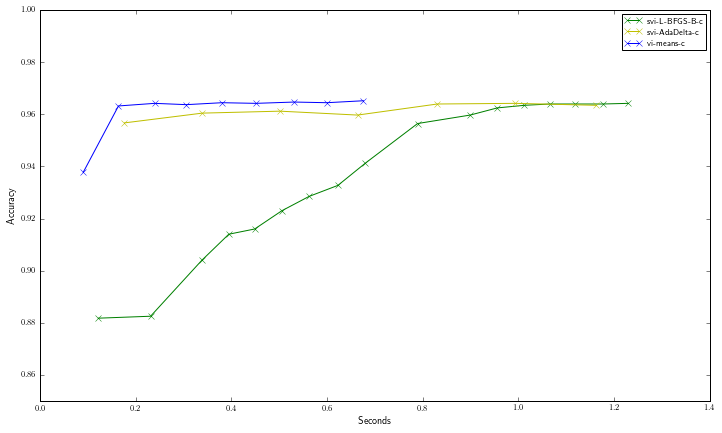

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:18], svi_y_lst[1:18], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:8], svi_ad_y_lst[1:8], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:10], vi_y_lst[1:10], '-bx', label='vi-means-c')
plt.ylim([0.85, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [20]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)